1. What kind of offers are in boston
2. Which is the most popular and what could the reason
3. first three factors that modifies the price.
4. can we predict it accurately

In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import scipy.stats as stats
%matplotlib inline


In [2]:
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

boston = pd.read_csv('Boston/listings.csv')

seattle = pd.read_csv('Seattle/listings.csv')

The size of the datasets!

In [3]:
num_rows_b = boston.shape[0] 
num_cols_b = boston.shape[1] 

print ('Boston dataset contains:', num_cols_b , 'variables and the size of the dataset is:', num_rows_b )

num_rows_s = seattle.shape[0] 
num_cols_s = seattle.shape[1] 

print ('Seattle dataset contains:', num_cols_s , 'variables and the size of the dataset is:', num_rows_s )

Boston dataset contains: 95 variables and the size of the dataset is: 3585
Seattle dataset contains: 92 variables and the size of the dataset is: 3818


Let's see which are the different variables between two citys.

In [4]:
print ('the variables which are in Boston dataset and are not in Seattle dataset')
list(set(list(boston.columns)) - set(list(seattle.columns)))

the variables which are in Boston dataset and are not in Seattle dataset


['interaction', 'access', 'house_rules']

In [5]:
print ('the variables which are in Seattle dataset and are not in Boston dataset')
list(set(list(seattle.columns)) - set(list(boston.columns)))

the variables which are in Seattle dataset and are not in Boston dataset


[]

As a result, boston dataset has extra three variables. 
As a first step, lets see what information is carried by these variables.

In [6]:
diff_columns = boston[['house_rules', 'interaction', 'access']]

Let's breafly look at variables.

In [7]:
var_list = list(boston.columns)

As a first step, define variables which are constant. 

In [8]:
def constantlist (df, listofvar):
    
    '''
        INPUT:   dataframe and list of variables of interest
        OUTPUT:  list of constant variables
    '''
    
    constlist = []
    
    for var in listofvar:
        result = len(set(df[var])) == 1   
    
        if result :
            constlist.append(var)
            
    return constlist        

In [9]:
consts = constantlist(boston, var_list)

In [10]:
bostonvarlist = list(set(list(boston.columns)) - set(consts))

Price in thes dataset is not a float value but string. 

In [11]:
def Pstringtofloat(column):
    for i in range (0,num_rows_b):
        if isinstance(column[i], str) == False:
            continue
        if "," in column[i]:
            column[i]=column[i].replace(",","")
        column[i]=column[i].replace("$","")
    column = column.apply(pd.to_numeric, downcast='float', errors='coerce')    
    return column    

In [12]:
boston.price = Pstringtofloat(boston.price)

C:\Users\Gmchedlidze\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Gmchedlidze\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
boston.cleaning_fee = Pstringtofloat(boston.cleaning_fee)

C:\Users\Gmchedlidze\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


choos the variables that have an influence on price and then build the model.

In [14]:
bostondf = boston[bostonvarlist]

Lets check variable list on Nan values and diced remove these variables or repair somehow.

In [15]:
isnull80 =[]
isnull60 =[]
isnull20 =[]
isnull20mean=[]
isnullless20 =[]
isnullless20mean = []
for var in bostonvarlist:
    isnullmean = bostondf[var].isnull().mean()
    if isnullmean>= 0.8:
        isnull80.append(var)
    if isnullmean< 0.8 and isnullmean>= 0.6: 
        isnull60.append(var)
    if isnullmean< 0.6 and isnullmean>= 0.2: 
        isnull20.append(var) 
        isnull20mean.append(isnullmean)
    if isnullmean< 0.2 and isnullmean> 0.: 
        isnullless20.append(var)
        isnullless20mean.append(isnullmean)
        #print (var,"  ", bostondf[var].isnull().mean())       

These columns can be ignored from dataset. 

###isnull lists

In [16]:
print ("is empty >= 80% cases")
print(isnull80)
print ("is empty < 80% and >= 60% cases")
print(isnull60)
print ("is empty < 60% and >= 20% cases")
print (isnull20)

is empty >= 80% cases
['neighbourhood_group_cleansed', 'has_availability', 'square_feet', 'jurisdiction_names', 'license']
is empty < 80% and >= 60% cases
['security_deposit', 'weekly_price', 'monthly_price']
is empty < 60% and >= 20% cases
['transit', 'review_scores_communication', 'house_rules', 'space', 'host_about', 'last_review', 'interaction', 'notes', 'review_scores_accuracy', 'reviews_per_month', 'access', 'neighborhood_overview', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_checkin', 'review_scores_value', 'cleaning_fee', 'first_review']


We can repare has_availability variable but lets remove it from the list for now.
We can also assume that weekly/monthly price is price per nite times 7/30, also security deposit is 0 if is not provided, but at these stage remove these variables too. 
lets see >=20% variables more close.

If the variable gets less than 20 meanings put it in repairlist and discuss afterwords worth to keep that variables or  not.

In [17]:
repairlist20 = []
for i in range(0,len(isnull20)):
    N_groups = len(bostondf.groupby(isnull20[i]).count())
    print(isnull20[i],':  ',N_groups, "isnanmean: ", isnull20mean[i] )
    if N_groups <20:
        repairlist20.append(isnull20[i])
        


transit :   1859 isnanmean:  0.3598326359832636
review_scores_communication :   7 isnanmean:  0.22817294281729428
house_rules :   1928 isnanmean:  0.33249651324965135
space :   2268 isnanmean:  0.29483960948396093
host_about :   1240 isnanmean:  0.36513249651324964
last_review :   404 isnanmean:  0.2108786610878661
interaction :   1617 isnanmean:  0.43347280334728033
notes :   1269 isnanmean:  0.5509065550906556
review_scores_accuracy :   8 isnanmean:  0.2295676429567643
reviews_per_month :   644 isnanmean:  0.2108786610878661
access :   1762 isnanmean:  0.41534170153417016
neighborhood_overview :   1728 isnanmean:  0.3947001394700139
review_scores_rating :   48 isnanmean:  0.22677824267782426
review_scores_cleanliness :   9 isnanmean:  0.22817294281729428
review_scores_location :   9 isnanmean:  0.2292887029288703
review_scores_checkin :   8 isnanmean:  0.22873082287308227
review_scores_value :   9 isnanmean:  0.2290097629009763
cleaning_fee :   79 isnanmean:  0.3087866108786611
first

In [18]:
repairlist= []
for i in range(0,len(isnullless20)):
    N_groups = len(bostondf.groupby(isnullless20[i]).count())
    print(isnullless20[i],':  ',N_groups, "isnanmean: ", isnullless20mean[i] )
    if N_groups < 20 or isnullless20mean[i]<0.05 :
        repairlist.append(isnullless20[i])
        

host_acceptance_rate :   72 isnanmean:  0.13138075313807532
host_response_time :   4 isnanmean:  0.13138075313807532
thumbnail_url :   2986 isnanmean:  0.16708507670850767
host_response_rate :   52 isnanmean:  0.13138075313807532
bedrooms :   6 isnanmean:  0.002789400278940028
medium_url :   2986 isnanmean:  0.16708507670850767
city :   38 isnanmean:  0.0005578800557880056
market :   4 isnanmean:  0.003905160390516039
property_type :   13 isnanmean:  0.0008368200836820083
summary :   3113 isnanmean:  0.039888423988842396
beds :   11 isnanmean:  0.002510460251046025
neighbourhood :   30 isnanmean:  0.1514644351464435
xl_picture_url :   2986 isnanmean:  0.16708507670850767
zipcode :   43 isnanmean:  0.010599721059972107
host_location :   176 isnanmean:  0.0030683403068340305
bathrooms :   12 isnanmean:  0.003905160390516039
host_neighbourhood :   53 isnanmean:  0.09456066945606695


See which variables passed the first selection.

In [19]:
var_list = list(set(bostonvarlist) - (set(isnull20) - set(repairlist20)) - (set(isnullless20) -set(repairlist)) - set(isnull60) - set (isnull80))

Texted URL-s dont give any information, so we can remove them too.

In [20]:
removelist = []
for var in var_list:
    if 'url' in var:
        removelist.append(var)

In [21]:
var_list = list(set(var_list) - set (removelist))

Below is the list of variables which will not be considerd in the analysis. 

In [22]:
remove_vars = ['notes','listing_url','host_url','host_verifications','xl_picture_url','host_picture_url','thumbnail_url','medium_url','city','neighborhood_overview','transit','last_review','reviews_per_month','interaction','first_review']
var_list = list(set(bostonvarlist) -set(remove_vars) - set(isnull60)- set (isnull80))

In [23]:
var_miss_val = []
for var in var_list:
    isnullmean = bostondf[var].isnull().mean()
    if isnullmean>0.:
        var_miss_val.append(var)
        print (var,"  ", bostondf[var].isnull().mean())

review_scores_communication    0.22817294281729428
house_rules    0.33249651324965135
space    0.29483960948396093
host_acceptance_rate    0.13138075313807532
host_about    0.36513249651324964
host_response_time    0.13138075313807532
host_response_rate    0.13138075313807532
bedrooms    0.002789400278940028
review_scores_accuracy    0.2295676429567643
market    0.003905160390516039
access    0.41534170153417016
review_scores_rating    0.22677824267782426
property_type    0.0008368200836820083
summary    0.039888423988842396
review_scores_cleanliness    0.22817294281729428
beds    0.002510460251046025
review_scores_location    0.2292887029288703
neighbourhood    0.1514644351464435
review_scores_checkin    0.22873082287308227
review_scores_value    0.2290097629009763
cleaning_fee    0.3087866108786611
zipcode    0.010599721059972107
host_location    0.0030683403068340305
bathrooms    0.003905160390516039
host_neighbourhood    0.09456066945606695


check what kind of offers are existing for boston

In [122]:
var_list

['room_type',
 'neighbourhood',
 'minimum_nights',
 'smart_location',
 'space',
 'instant_bookable',
 'id',
 'host_neighbourhood',
 'price',
 'amenities',
 'bedrooms',
 'bathrooms',
 'availability_365',
 'market',
 'host_identity_verified',
 'availability_90',
 'beds',
 'guests_included',
 'house_rules',
 'host_has_profile_pic',
 'calculated_host_listings_count',
 'host_name',
 'host_response_time',
 'host_location',
 'availability_30',
 'host_listings_count',
 'neighbourhood_cleansed',
 'availability_60',
 'review_scores_rating',
 'host_about',
 'access',
 'host_response_rate',
 'street',
 'host_acceptance_rate',
 'host_thumbnail_url',
 'host_total_listings_count',
 'is_location_exact',
 'description',
 'zipcode',
 'maximum_nights',
 'number_of_reviews',
 'name',
 'host_id',
 'review_scores_value',
 'latitude',
 'cleaning_fee',
 'summary',
 'accommodates',
 'review_scores_communication',
 'extra_people',
 'property_type',
 'review_scores_cleanliness',
 'picture_url',
 'calendar_update

#### zipcode
we can repare zipcode  and neighbourhood by latitude and longitude

In [ ]:
# dataframe where zip code exists
exist_zip = bostondf[bostondf['neighbourhood'] != bostondf['neighbourhood'].isnull()] 
# dataframe with missing zipcode
no_zip = bostondf[bostondf['neighbourhood'].isnull()]

for lat in no_zip.latitude:
    subset_df = exist_zip[exist_zip.latitude == lat]
    for long in no_zip.longitude:
         print(exist_zip[exist_zip.longitude == long].neighbourhood)

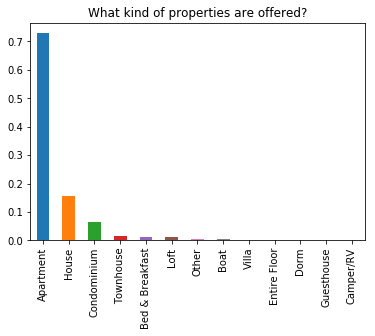

In [24]:
Ptype = bostondf.property_type.value_counts() #Provide a pandas series of the counts for each property type

# The below should be a bar chart of the proportion of individual property type category.
(Ptype/bostondf.shape[0]).plot(kind="bar");
plt.title("What kind of properties are offered?");
#bostondf.groupby(['property_type']).count()

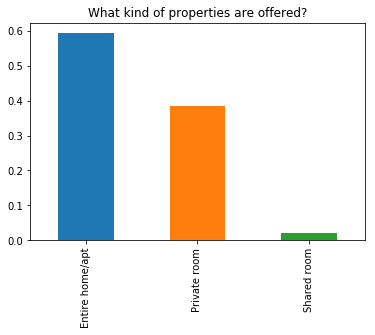

In [25]:
Rtype = bostondf.room_type.value_counts() #Provide a pandas series of the counts for each property type

# The below should be a bar chart of the proportion of individual property type category.
(Rtype/bostondf.shape[0]).plot(kind="bar");
plt.title("What kind of properties are offered?");

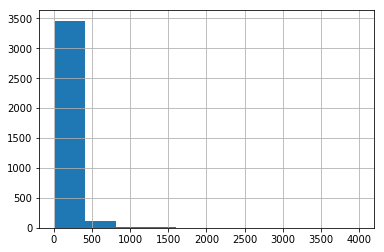

In [37]:
bostondf.price.hist()

In [26]:
table = pd.pivot_table(data=bostondf, values='price', index='property_type', columns='room_type', aggfunc='mean')
print (table)

room_type        Entire home/apt  Private room  Shared room
property_type                                              
Apartment             222.479025     98.726463    84.596774
Bed & Breakfast       142.500000    130.921053    44.000000
Boat                  265.200000    287.000000          NaN
Camper/RV              60.000000           NaN          NaN
Condominium           234.640000    109.000000    70.000000
Dorm                         NaN     62.500000          NaN
Entire Floor          154.000000     90.000000          NaN
Guesthouse            289.000000           NaN          NaN
House                 276.337838     80.246914    62.333333
Loft                  217.068966     96.250000    83.000000
Other                 324.500000    181.363636   316.250000
Townhouse             268.357143    107.275000          NaN
Villa                 263.500000    152.500000          NaN


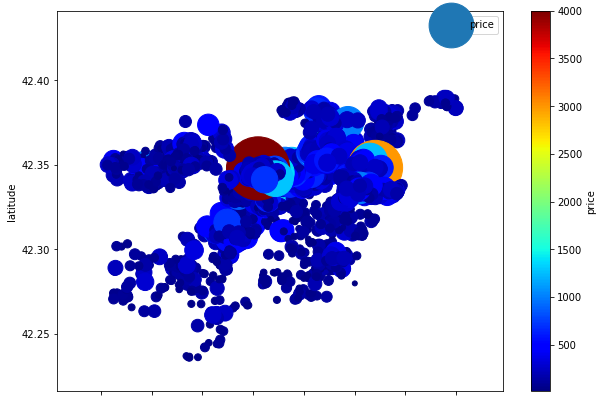

In [34]:
bostondf.plot(kind="scatter", x="longitude", y="latitude",
    s=bostondf['price'], label="price",
    c="price", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=1, figsize=(10,7),
)
plt.legend()
plt.show()


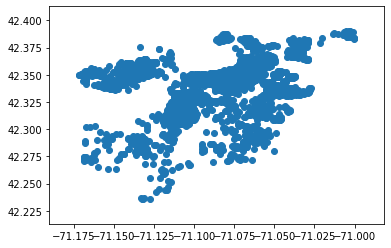

In [186]:
import matplotlib.pyplot as plt
plt.scatter(x=bostondf['longitude'], y=bostondf['latitude'])
plt.show()

Let's check categorical variables

In [54]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [60]:
cat_df = bostondf[var_list].select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

#df_new = create_dummy_df(cat_df, cat_cols_lst, dummy_na=False) #Use your newly created function

In [56]:
cat_df.host_is_superhost

0       f
1       f
2       t
3       f
4       t
       ..
3580    f
3581    f
3582    f
3583    f
3584    f
Name: host_is_superhost, Length: 3585, dtype: object

In [61]:
cat_df.head()

,room_type,neighbourhood,smart_location,space,instant_bookable,host_neighbourhood,amenities,market,host_identity_verified,house_rules,...,extra_people,property_type,picture_url,calendar_updated,host_since,bed_type,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,host_is_superhost
0,Entire home/apt,Roslindale,"Boston, MA",The house has an open and cozy feel at the sam...,f,Roslindale,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",Boston,f,Clean up and treat the home the way you'd like...,...,$0.00,House,https://a2.muscache.com/im/pictures/c0842db1-e...,2 weeks ago,2015-04-15,Real Bed,f,f,moderate,f
1,Private room,Roslindale,"Boston, MA",Small but cozy and quite room with a full size...,t,Roslindale,"{TV,Internet,""Wireless Internet"",""Air Conditio...",Boston,t,Pet friendly but please confirm with me if the...,...,$0.00,Apartment,https://a1.muscache.com/im/pictures/39327812/d...,a week ago,2012-06-07,Real Bed,f,f,moderate,f
2,Private room,Roslindale,"Boston, MA","Come stay with a friendly, middle-aged guy in ...",f,Roslindale,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",Boston,t,"I encourage you to use my kitchen, cooking and...",...,$20.00,Apartment,https://a2.muscache.com/im/pictures/6ae8335d-9...,5 days ago,2009-05-11,Real Bed,t,f,moderate,t
3,Private room,NaN,"Boston, MA",Most places you find in Boston are small howev...,f,NaN,"{TV,Internet,""Wireless Internet"",""Air Conditio...",Boston,f,- The bathroom and house are shared so please ...,...,$25.00,House,https://a2.muscache.com/im/pictures/39764190-1...,a week ago,2013-04-21,Real Bed,f,f,moderate,f
4,Private room,Roslindale,"Boston, MA","Clean, attractive, private room, one block fro...",f,Roslindale,"{Internet,""Wireless Internet"",""Air Conditionin...",Boston,t,"Please no smoking in the house, porch or on th...",...,$0.00,House,https://a1.muscache.com/im/pictures/97154760/8...,2 weeks ago,2014-05-11,Real Bed,f,f,flexible,t


These variables are expacted to be higly correleted with each other. Check the correlation between them and with the price and then choose which one to use.

In [ ]:
bostondf_isna20 = bostondf[reparablefrom20]
bostondf_isna20_0 = bostondf_isna20.dropna()
bostondf_isna20_1 = bostondf_isna20.fillna(bostondf_isna20.mean())

In [ ]:
for i in range(0,len(reparablefrom20)):
    print("\n")
    for j in range(1,len(reparablefrom20)):
        cor,pval  = stats.pearsonr(bostondf_isna20_1[reparablefrom20[i]],bostondf_isna20_1[reparablefrom20[j]])
        if 1.> cor >0.6:
            print (reparablefrom20[i],reparablefrom20[j] )
            print (cor)
    

In [ ]:
cat_df = bostondf_isna20.select_dtypes(include=['object'])
list(cat_df.columns)

In [ ]:
#Create a copy of the dataframe
cat_df_copy = cat_df.copy()
#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
            
    return df

In [ ]:
df_new = create_dummy_df(boston, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show shape to assure it has a shape of (5009, 11938)
print(df_new.shape)

In [18]:
bostondf[repairlist] =bostondf[repairlist].fillna(bostondf[repairlist].mean())

C:\ProgramData\Anaconda3_1\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''

    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_new, 'price', cat_cols_lst, dummy_na=False)

In [ ]:

boston.price

Print list of variables, which are constant

In [ ]:
isconstant(seattle, var_list )

In [ ]:
plt.scatter( boston.id, boston.scrape_id)

In [ ]:
import scipy.stats as stats
for i in range(0,2):
    for j in range(1,2):
        cor,pval  = stats.pearsonr(boston[var_list[i]],boston[var_list[j]])
        if 1>cor>abs(0.8):
            print (var_list[i], var_list[j] )
            print (cor, '\n')

In [ ]:
boston.describe()

In [ ]:
status_vals = seattle.host_id.value_counts()

In [ ]:
status_vals.head(10)